<a href="https://colab.research.google.com/github/ClaireWa/Python_ML-PMR_flavour/blob/master/BayesianPCA%26standardPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pystan
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import random
import numpy.linalg as la

In [0]:
code = """
data {
        int<lower=0> N; // Number of samples
	int<lower=0> D; // The original dimension
	int<lower=0> K; // The latent dimension
	matrix[N, D] X; // The data matrix
	real mu_W;      // Mean of prior of W
	real alpha0;    // hyperparam for gamma distr of alpha
	real beta0;     // hyperparam for gamma distr of alpha
}

parameters {
	matrix[N, K] Z; // The latent matrix
	matrix[D, K] W; // The weight matrix
	real<lower=0> tau; // Precision of X (noise term) 
	vector<lower=0>[K] alpha; // Precision of W
}

transformed parameters{
	vector<lower=0>[K] t_alpha;
	real<lower=0> t_tau;
	t_alpha = 1 ./ sqrt(alpha);
	t_tau = 1 ./ sqrt(tau);
}

model {
      tau ~ gamma(1, 1);
      alpha ~ gamma(alpha0, beta0);				
      for(k in 1:K) {
        W[,k] ~ normal(mu_W, t_alpha[k]);
      }	
      for(n in 1:N){
      	Z[n] ~ normal(0, 1);
	X[n] ~ normal(W * Z[n]', t_tau);
      }
} 
"""

sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5a5c16ba2c1532eb4f51b206ce186a25 NOW.


In [0]:
X_1 = [6.950646740646656552e-01, -4.859325904038511168e-01, 1.199665310159269360e+00, 
       -1.500564639503813247e+00, 1.046589595792177585e+00, -3.919275793143054409e-01, 
       6.791836476729603556e-01, 5.237820161229895799e-01, 1.708613359915442276e+00, 
       -2.304572304318611931e+00, -2.901853234173955576e-01, 1.574806991991873906e+00,
       -3.686506949654931864e-01, -5.659022855302459076e-01, -2.713224715456747371e-01]
X_2 = [-3.666197184342024490e-02, -6.581173297440267023e-01, 9.860377041753285443e-01, 
       -1.326949218520296458e+00, 7.239557942782447464e-01, -3.407979385835242514e-01, 
       5.171609251807368635e-01, 2.781469506536183856e-01, 6.921820455152720708e-01, 
       -1.415174943118219675e+00, -2.909416696315803574e-01, 6.928982264963062798e-01, 
       -2.159990523316022704e-01, -2.053933938917264224e-01, -2.961628695712526307e-02]
X_3=[-1.417846795007553784e-01, -2.872523793602910908e-02, -1.926139784730311055e-01, 
     2.453954429832126138e-01, 1.195810213348604129e-01, -1.788218466349852237e-03, 
     8.902599387877900561e-03, -3.149081757871563872e-03, -6.390198831448234973e-02, 
     -8.155385586014166077e-02, -2.901346149215791939e-02, 9.021375536552728169e-02, 
     -2.662070296081403553e-01, 1.643091293337956005e-02, -8.117585143928934821e-03]

X = np.column_stack([X_1, X_2, X_3])



In [0]:
data = {"N": 15, "D": 3, "K": 2, "X": X, "mu_W": 0, "alpha0": 1, "beta0": 1}
result = sm.sampling(data=data, iter=10000, chains=2, n_jobs=2)

In [0]:
# Extract W and tau values
W = result.extract()["W"]
tau = result.extract()["tau"]

In [0]:
# Set random seed to keep data constant for random sample 
np.random.seed(2523694)
num_samples = 25

# Choose random sample of 25 from 10,000 samples
samples = np.random.randint(0, 10000, size=(num_samples,))
W_n = W[samples, ...]
tau_n = tau[samples]

# Compute covariance matrix for each of 25 randomly picked samples
C_n = np.zeros((num_samples, 3, 3))
for i in range(W_n.shape[0]):
    C_n[i] = np.dot(W_n[i,...], W_n[i,...].T)  + 1/tau_n[i]

# Compute eigenvectors and eigenvalues
vals = np.zeros((samples.size, 2))
vecs = np.zeros((samples.size, 3, 2))
for i, c in enumerate(C_n):
    e_vals, e_vecs = np.linalg.eig(c)
    # Select eigenvectors with largest two eigenvalues
    vals[i,:] = e_vals[e_vals!=np.min(e_vals)]
    vecs[i, ...] = e_vecs[:, e_vals!=np.min(e_vals)]

# Rescale the eigenvectors using provided equation
u = vecs* np.sqrt(vals[:, None, :])    


In [0]:
# Compute standard non-probabilistic PCA
# Standard PCA requires the data to be centred 
# Centre by subtracting mean to give zero mean
# X is in wrong shape so transpose
X_ = X.T - np.mean(X.T, axis=1, keepdims=True)
# Get empirical covariance matrix
Cov_emp = np.dot(X_, X_.T)/(X_.shape[-1]-1)
alpha, V = np.linalg.eig(Cov_emp)
# Select eigenvectors with largest two eigenvalues 
max = alpha[alpha!=np.min(alpha)]
V = V[:, alpha!=np.min(alpha)]
# Rescale the eigenvectors according to equation provided
U = V.T * np.sqrt(max[:, None])

# Eigenvectors signs need to be changed if not positive in order to align them
ut = (np.swapaxes(u,  1, 2))
for i, j in enumerate(ut[:, :, 0]):
    if j[0] < 0:
        ut[i, 0, :] *= -1
    if j[1] < 0:
        ut[i, 1, :] *= -1

In [0]:
# Get negative values for plot
U_neg = -U
ut_neg = -ut
# Compute mean of ut eigenvector 
u_mean = np.mean(ut, axis=0)
u_mean_neg = -u_mean

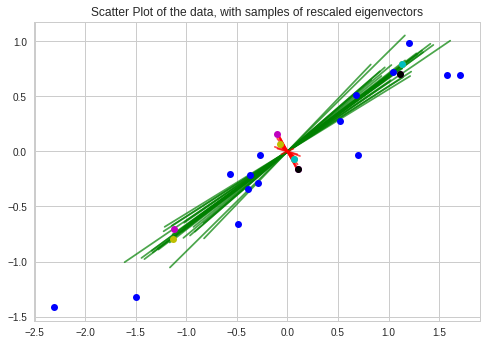

In [0]:
# eigs as lines
plt.plot([ut_neg[:,0, 0], ut[:, 0, 0]], [ut_neg[:,0, 1], ut[:, 0, 1]], 
         'g', alpha=0.7) 

plt.plot([ut_neg[:,1, 0], ut[:, 1, 0]], [ut_neg[:,1, 1], ut[:, 1, 1]], 
         'r' , alpha=0.7) 

# data and rescaled eigs as points
plt.plot(X.T[0,:], X.T[1,:], 'bo')
plt.plot([U[:, 0], U_neg[:, 0]], [U[:,1], U_neg[:, 1]], 'mo')
plt.plot(U[:, 0], U[:, 1],  'ko')
plt.plot([u_mean[:, 0], u_mean_neg[:, 0]], [u_mean[:,1], u_mean_neg[:, 1]], 'yo')
plt.plot(u_mean[:, 0], u_mean[:, 1],  'co')
plt.title("Scatter Plot of the data, with samples of rescaled eigenvectors")
plt.show()




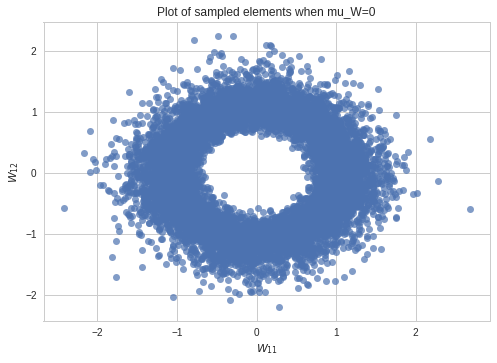

In [0]:

plt.plot(W[:,0,0], W[:, 0, 1], 'o', alpha=0.7)
plt.xlabel(r'$W_{11}$')
plt.ylabel(r'$W_{12}$')
plt.title("Plot of sampled elements when mu_W=0")
plt.show()

In [0]:
data= {"N": 15, "D": 3, "K": 2, "X":X, "mu_W": 1, "alpha0": 1, "beta0": 1}
result2=sm.sampling(data=data,iter=10000,chains=2,n_jobs=2)


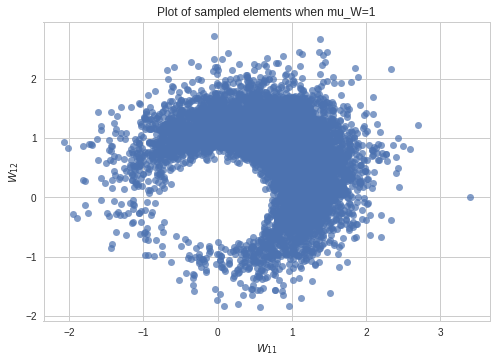

In [0]:
W2 = result2.extract()['W']
plt.plot(W2[:,0,0], W2[:, 0, 1], 'o', alpha=0.7)
plt.xlabel(r'$W_{11}$')
plt.ylabel(r'$W_{12}$')
plt.title("Plot of sampled elements when mu_W=1")
plt.show()